# Описание работы

## Исходные данные


base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

## Задача

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

- оценить качество алгоритма по метрике accuracy@5

# Импорт библиотек

In [ ]:
!pip install faiss-gpu
!pip install phik

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import phik

import faiss
from tqdm.notebook import tqdm
import requests
import zipfile

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Настрока окружения

In [ ]:
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:,.5f}'.format)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [ ]:
RANDOM_STATE = 314159

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


# Загрузка данных и EDA

In [ ]:
%%time
df_base = pd.read_csv("base.csv", index_col=0)
df_train = pd.read_csv("train.csv", index_col=0)
df_valid = pd.read_csv("validation.csv", index_col=0)
df_answer = pd.read_csv("validation_answer.csv", index_col=0)

df_base.head()

CPU times: user 1min 4s, sys: 7.22 s, total: 1min 11s
Wall time: 1min 47s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.08389,11.15291,-64.42676,-118.88089,216.48244,-104.69806,-469.07059,44.34808,120.91534,181.44970,-124.06151,-32.45824,-57.42056,36.20741,182.71677,-28.07169,-5.20937,-1.73218,-91.09186,-79.46667,-103.93909,"1,507.23127",-32.59167,51.41436,-51.90536,813.77007,-41.55654,8.41981,-129.97664,148.76503,-10.06923,-143.00504,79.84869,-537.18371,2.77318,111.51868,4.25767,-153.34058,-123.62608,-39.70766,-12.76871,-4.17011,-152.96713,75.91152,-57.47009,17.26648,-98.87116,-138.06754,91.00038,-170.70200,-50.02039,59.79430,78.10638,-89.37573,89.41210,79.81218,-129.51361,-44.65950,-80.44221,5.14971,-64.51895,-138.77763,-42.80869,38.80083,-151.76218,-74.38909,63.66634,-4.70386,92.93361,115.26919,-112.75664,-60.83035
1-base,-34.56220,13.33276,-69.78761,-166.53348,57.68061,-86.09837,-85.07667,-35.63744,119.71864,195.23419,-141.30435,-126.76890,-68.85353,8.31472,143.08174,8.77826,15.15719,48.24636,-244.95486,-80.27942,-81.78804,429.88004,-5.93769,70.14265,66.57684,813.77007,3.21437,17.16430,-39.41839,148.15588,-7.57959,-174.36995,101.22463,-303.93923,16.91463,53.39468,33.45182,-148.55263,-110.34017,-33.27721,-8.68870,13.65030,-91.22875,38.44501,-31.94847,62.48482,-166.47336,-189.01042,-56.73156,-30.02732,59.17106,-56.71154,63.54261,-121.31917,97.42606,74.83284,-138.77705,58.88761,-71.59534,-251.95236,11.39285,-148.57166,-117.76753,41.10000,-157.82940,-94.44681,68.20211,24.34685,179.93793,116.83400,-84.88894,-59.52461
2-base,-54.23375,6.37937,-29.21014,-133.41383,150.89583,-99.43533,52.55480,62.38171,128.95145,164.38147,-140.82245,-22.48675,-51.66699,2.52173,140.58545,-22.03923,-7.12863,-5.18479,-111.71212,-79.02927,-82.45258,"1,507.23127",-0.42101,84.10801,63.34451,813.77007,-105.21105,18.84470,-94.78947,151.38771,-21.48344,-144.84537,48.50293,-780.44918,64.76731,79.78155,-13.39014,-150.06166,-118.75855,-40.89629,-15.22262,-1.86034,-93.82066,98.74907,-46.74578,65.92748,-10.28639,-125.32137,21.04861,-22.63778,68.91599,-54.90226,66.33547,-142.92792,83.03098,69.97963,-123.73389,65.32088,-114.03718,-529.39696,-101.58137,-134.65822,-76.39780,46.01180,-207.14442,127.32557,65.56618,66.32568,81.07349,116.59415,"-1,074.46489",-32.52721
3-base,-87.52013,4.03788,-87.80303,-185.06763,76.36954,-58.98517,-383.18284,-33.61124,122.03191,136.23358,-108.47044,-104.53778,-82.38849,-79.98674,113.59631,-38.99588,-4.78736,8.32781,-124.85576,-79.10902,-107.94327,"1,479.17053",-125.27161,24.65648,-16.92105,813.77007,-182.68027,14.71570,-62.93270,151.20198,10.61345,-134.93434,58.77773,-529.29505,43.66592,92.80630,-38.93666,-145.04530,-124.29577,-36.87673,-17.74287,10.53624,-124.58415,121.91415,-17.32136,105.21724,-94.37965,-63.76927,29.21749,-26.42397,5.86983,64.06155,63.51328,-112.25810,80.92659,72.63610,-137.31432,7.91255,-62.18892,-540.32104,-89.58871,-149.32669,-70.64794,-6.35892,-147.20105,-37.69275,66.20289,-20.56691,137.20694,117.47410,"-1,074.46489",-72.91549
4-base,-72.74385,6.52205,43.67126,-140.60803,5.82002,-112.07408,-397.71128,45.18250,122.16718,112.11906,-110.34245,-38.98206,-50.22887,-26.69092,135.27290,-7.51010,8.92421,111.57695,-130.83319,-79.31585,-57.84395,"1,262.91974",19.22591,59.81181,76.15967,312.69890,-76.72697,21.29992,-24.06911,167.38553,-44.05947,-148.13185,98.04261,-657.52439,96.36317,71.06152,-36.56356,-135.37244,-123.70898,-44.73944,-10.85522,8.35480,-168.32886,215.92807,-32.97598,66.86488,30.83863,-211.54037,57.69534,-67.82263,-29.38913,-34.12374,54.71055,-26.03201,90.67391,58.08700,-134.78206,77.62039,-176.61588,-529.76241,-100.56552,-125.31733,-57.19910,56.64240,-159.35184,85.94472,66.76632,-2.50578,65.31529,135.05159,"-1,074.46489",0.31940


In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


Данные объемные, можно сэкономить немного места в помяти преобразовав тип данных во float32

In [ ]:
df_base = df_base.astype(np.float32)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


In [ ]:
df_base.describe().T

,count,mean,std,min,25%,50%,75%,max
0,"2,918,139.00000",-86.22946,24.89132,-199.46870,-103.06544,-86.23150,-69.25658,21.51555
1,"2,918,139.00000",8.08007,4.95339,-13.91461,4.70849,8.03895,11.47007,29.93721
2,"2,918,139.00000",-44.58079,38.63166,-240.07339,-69.55949,-43.81660,-19.62527,160.93723
3,"2,918,139.00000",-146.63501,19.84480,-232.66714,-159.90506,-146.77681,-133.32765,-51.37478
4,"2,918,139.00000",111.31658,46.34809,-105.58296,80.50795,111.87300,142.37428,319.66449
5,"2,918,139.00000",-71.99137,28.18607,-211.00861,-91.37994,-71.92230,-52.44110,58.80624
6,"2,918,139.00000",-392.22372,271.65500,-791.46985,-629.33185,-422.20163,-156.66859,109.63253
7,"2,918,139.00000",20.35283,64.21638,-301.85974,-22.22147,20.80477,63.91821,341.22821
8,"2,918,139.00000",123.68429,6.35611,93.15305,119.48398,123.89225,127.97048,152.26120
9,"2,918,139.00000",124.45811,64.43058,-173.87195,81.76751,123.49770,167.22060,427.54205


In [ ]:
df_base.duplicated().sum()

0

Явных дубликатов не обнаружено.  
Напишем функцию которая рисует гистограмму и диаграмму размаха для каждого признака чтобы посмотреть на них подробнее.

In [ ]:
def num_descr(data, column, bins):

    x=data[column]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(16,8))

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=bins, ax=ax_hist)

    ax_box.set_title(f'Распределение признака {column}')
    ax_box.set(yticks=[])
    ax_box.set(xlabel='')
    ax_hist.set(xlabel='Value')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()


    print(f'Описание признака {column}:\n')
    print(x.describe())

In [ ]:
%%time
for col in df_base.columns:
    num_descr(df_base.sample(250000, random_state=RANDOM_STATE), col, 50)

Output hidden; open in https://colab.research.google.com to view.

## Матрица корреляции

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71']
CPU times: user 8min 30s, sys: 10 s, total: 8min 40s
Wall time: 10min 32s


Text(0.5, 1.0, 'Тепловая карта коэффициентов корреляции Фи')

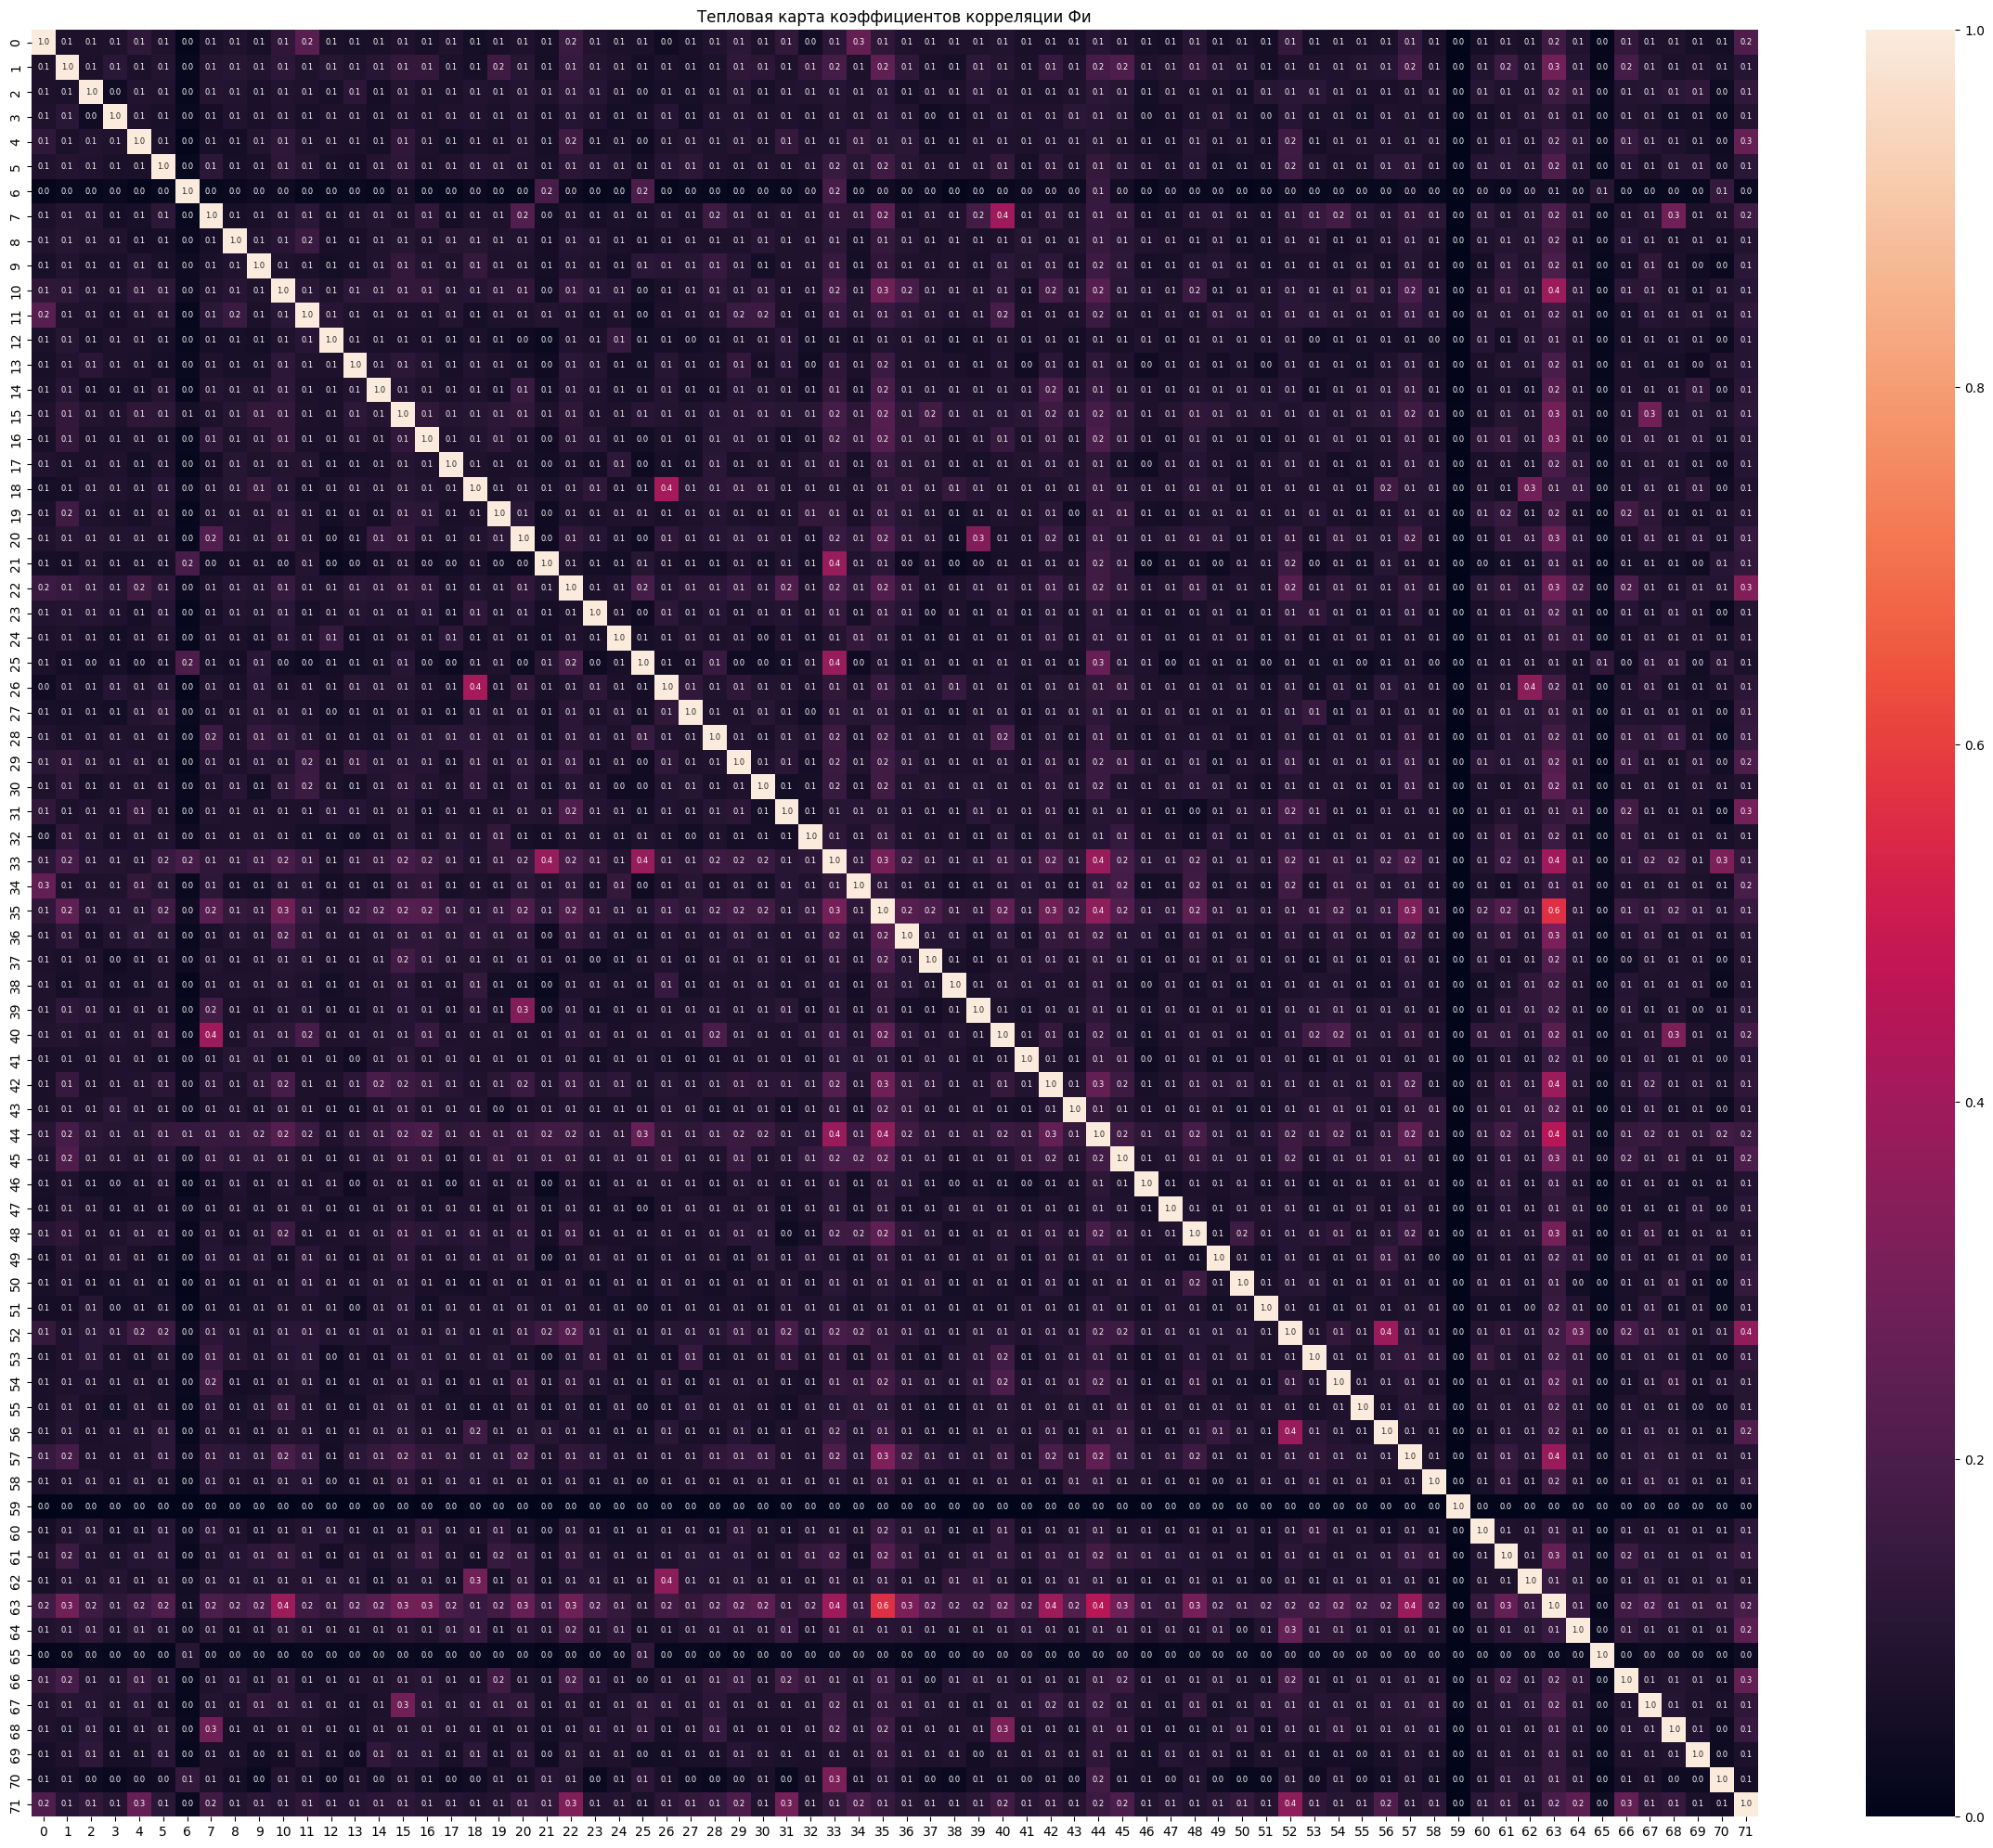

In [ ]:
%%time

plt.figure(figsize=(30, 25))
sns.heatmap(df_base.sample(250000, random_state=RANDOM_STATE)
           .phik_matrix(),
            annot=True, fmt='.1f', annot_kws={'fontsize':6})
plt.title('Тепловая карта коэффициентов корреляции Фи');

In [ ]:
outliers = ['6','21','25','70','63','33','44','59','65']
not_norm = []

## Вывод по данным
- Данные загружены и подготовлены. Я смотрел только базовый датасет так как остальные являются производными от него.  
- Признаки имеют различный масштаб, потребуется масштабирвоание.
- Часть признаков распространены ненормально:  
 * признаки 6, 21, 25, 70 имеют равномерное распределение с пиками. Такие признаки плохо характеризуют товар, их можно будет удалить.
 * столбцы с равномерным распределнием изначально решено было оставить и нормализовать, однако опыты показали что их удаление положительно влияет на метрику.
- признак 63 показывает связь средней силы с другими признаками, принято решение удалить его как мультиколлинеарный.

# Базовая модель на сырых данных

In [ ]:
#dims = df_base.shape[1]
#n_cells = 1700
#quantizer = faiss.IndexFlatL2(dims)

#idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
#%%time
#idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
#idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [ ]:
#base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [ ]:
#targets = df_train["Target"]
#df_train.drop("Target", axis=1, inplace=True)

#targets_valid = df_answer['Expected']

In [ ]:
#%%time
#candidate_number = 5
#r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), candidate_number)

#Accuracy @ 5 = 11.3%

## Вывод
Для начала была предпринята попытка запустить базовую модель на "сырых" данных.  
Количество кластеров было выбрано с точки зрения ускорения расчета.  
Ожидаемо модель показала плохой результат (11.3%) так как изначальные данные нуждаются в предобработке.

# Улучшаем модель

In [ ]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

targets_valid = df_answer['Expected']

На первых итерациях была попытка нормализовать признаки, однако это не принесло желаемых результатов и для ускорения расчетов и повышеняи точности предсказания было принято решение их удалить.

In [ ]:
#df_base[not_norm] = preprocessing.normalize(df_base[not_norm], axis=0)
#df_train[not_norm] = preprocessing.normalize(df_train[not_norm], axis=0)

In [ ]:
df_base_scaled = df_base.drop(outliers, axis=1)
df_train_scaled = df_train.drop(outliers, axis=1)
df_valid_scaled = df_valid.drop(outliers, axis=1)

In [ ]:
scaler = RobustScaler()

Масштабируем данные. Модель начала работать заметно быстрее и точнее.
Время выполнения расчетов уменьшилось с 39 минут до 5. Точность выросла с 11.3% до 53.7%.

In [ ]:
df_base_scaled = scaler.fit_transform(df_base_scaled)
df_train_scaled = scaler.fit_transform(df_train_scaled)
df_valid_scaled = scaler.fit_transform(df_valid_scaled)

Следующим шагом была попытка расчитать оптимальное количество кластеров.  
Однако я получил странные результаты. Вероятно, причиной явился дисбаланс классов. 1200 или даже 1700 кластеров давали результат хуже, чем 200 или 350.  
Было решено остановиться на 200, так как точность возрастала на 0.5% при замедленни работы на 5 минут.



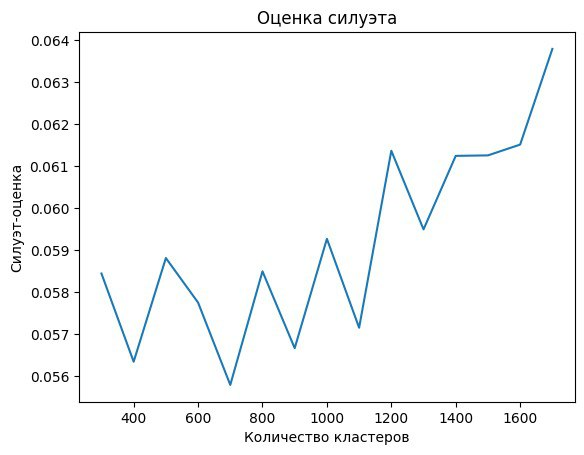

In [ ]:
def optimal_num_clusters(X, a, b, max_clusters):
  """
  Определяет оптимальное количество кластеров для данных с помощью метода локтя и силуэта.

  Args:
      X: Массив данных.
      max_clusters: Максимальное количество кластеров для проверки.
      a: начальное количество кластеров.
      b: размер шага.

  Returns:
      Оптимальное количество кластеров.
  """

  inertia = []
  silhouette_scores = []

  for k in range(a, max_clusters + 1, b):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

  # Метод локтя
  plt.plot(range(a, max_clusters + 1, b), inertia)
  plt.xlabel("Количество кластеров")
  plt.ylabel("Inertia")
  plt.title("Метод локтя")
  plt.show()

  # Оценка силуэта
  plt.plot(range(a, max_clusters + 1, b), silhouette_scores)
  plt.xlabel("Количество кластеров")
  plt.ylabel("Силуэт-оценка")
  plt.title("Оценка силуэта")
  plt.show()

  # Нахождение оптимального k
  optimal_k = silhouette_scores.index(max(silhouette_scores)) * b + a
  print(f"Оптимальное количество кластеров по методу силуэта: {optimal_k}")

  return optimal_k

In [ ]:
#optimal_num_clusters(df_base_scaled[:10000], 200, 100, 2000)

In [ ]:
def optimal_num_clusters_dbi(X, a, b, max_clusters):
  """
  Определяет оптимальное количество кластеров для данных с помощью
  коэффициента схожести кластеров Дэвиса-Болдина.

  Args:
      X: Массив данных.
      max_clusters: Максимальное количество кластеров для проверки.
      a: начальное количество кластеров.
      b: размер шага.

  Returns:
      Оптимальное количество кластеров.
  """

  dbi_scores = []

  for k in range(a, max_clusters + 1, b):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    dbi_scores.append(davies_bouldin_score(X, kmeans.labels_))

  # Нахождение оптимального k
  optimal_k = dbi_scores.index(min(dbi_scores)) * b + a
  print(f"Оптимальное количество кластеров по DBI: {optimal_k}")

  # Визуализация

  plt.plot(range(a, max_clusters + 1, b), dbi_scores)
  plt.xlabel("Количество кластеров")
  plt.ylabel("Davies-Bouldin index")
  plt.title("Оценка DBI")
  plt.show()

  return optimal_k

In [ ]:
#k = optimal_num_clusters_dbi(df_base_scaled[:10000], 200, 100, 2000)

Создаем “плоский” индекс IndexFlatL2, который будет использоваться для квантизации векторов внутри каждой группы. IndexFlatL2 вычисляет расстояния между векторами по евклидовой метрике.  

Далее создаем индекс IndexIVFFlat, который использует IndexFlatL2 в качестве квантизатора. Этот индекс будет разбивать векторы на 200 групп.

In [ ]:
dims = df_base_scaled.shape[1]
#n_cells = k
n_cells = 200
quantizer = faiss.IndexFlatL2(dims)

idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

Дополнительные 15% точности принесло изменение параметра .nprobe.

In [ ]:
idx_l2.nprobe = 5

In [ ]:
idx_l2.train(np.ascontiguousarray(df_base_scaled).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_scaled).astype('float32'))

In [ ]:
%%time
candidate_number = 5
r, idx = idx_l2.search(np.ascontiguousarray(df_train_scaled).astype('float32'), candidate_number)

CPU times: user 14min 38s, sys: 1.39 s, total: 14min 40s
Wall time: 8min 58s


In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 69.3%


# Пробуем другие индексы

In [ ]:
# Увеличение значения приведет к повышению точности, но замедлению работы.
ef_search = 32

In [ ]:
idx_hnsw = faiss.index_factory(dims,
             (f'IVF{n_cells}_HNSW'+ f'{ef_search}'+',Flat'))

In [ ]:
idx_hnsw.nprobe = 5

In [ ]:
idx_hnsw.train(np.ascontiguousarray(df_base_scaled))
idx_hnsw.add(np.ascontiguousarray(df_base_scaled))

In [ ]:
%%time
r2, idx2 = idx_hnsw.search(np.ascontiguousarray(df_train_scaled).astype('float32'), candidate_number)

CPU times: user 15min, sys: 1.5 s, total: 15min 1s
Wall time: 9min 7s


In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx2.tolist()):
    acc += int(target in [base_index[r2] for r2 in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx2):.1%}')

Accuracy @ 5 = 69.0%


HNSW строит граф, связывающий точки данных в пространстве признаков.
ef_search определяет, сколько кандидатов будет рассмотрено на каждом шаге. Чем больше значение ef_search, тем больше кандидатов будет проверено, что потенциально повысит точность поиска.

Данный индекс должен обуспечивать более высокую точность, но, вероятно, показал хуже результат из-за низкого значения ef_search (нужно было задать 100+)

# Лучшая модель на валидационных данных

Так как IndexIVFFlat показал более высокую точность и скорость, используем его для расчета точности на тестовых данных.

In [ ]:
%%time
candidate_number = 5
r3, idx3 = idx_l2.search(np.ascontiguousarray(df_valid_scaled).astype('float32'), candidate_number)

CPU times: user 14min 40s, sys: 1.53 s, total: 14min 41s
Wall time: 8min 53s


In [ ]:
acc = 0
for target, el in zip(targets_valid.values.tolist(), idx3.tolist()):
    acc += int(target in [base_index[r3] for r3 in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx3):.1%}')

Accuracy @ 5 = 69.2%


# Вывод

Модель FAISS показала хорошую предсказательную способность, с accuracy5 = 69.2% на тестовых данных.  
Что можно улучшить в работе:
- попробовать другие индексы, например IndexIVFPQ.
- высчитать оптимальное количество кластеров, для этого необходимо сэмплировать данные (так как на полном объеме функция не справляется), при этом устранить дисбаланс классов.
- проанализировать важность признаков и отобрать наиболее релевантные (методом selectkbest?)
- применить ансаблевые методы
